In [19]:
suppressPackageStartupMessages(suppressWarnings({
    library(tidyr)
    library(ggplot2)
    library(dplyr)
    library(igraph)
    library(gtools)
    library(gridExtra)
    library(network)
    library(sna)
    library(ggnetwork)
    library(dagitty)
    #library(MRPC)
    library(glasso)
    library(corpcor)
}))

In [2]:
#data initialisation functions

# empty matrix dims p x p
# set to ident matrix
# rbinom <- number of observations, size of trials, probability of success
# scale() forces column centering by subtracting mean of each column from their data points
# d <- split each column into the list and add randomly distributed numbers to each element
# do.call(cbind, d) concatenates the list elements to reform the previous matrix representation

init_data <- function(n, p){
    r <- matrix(0, p, p)
    diag(r) <- 1
    g <- scale(matrix(rbinom(n*p, 2, 0.5), n))
    d <- list()
    for(i in 1:p){
        d[[i]] <- g[,i] + rnorm(n)
    }
    d <- do.call(cbind, d)
    return(list(r=r, d=d, g=g, p=p))
}

# r is a p x p ident matrix, this sets location j, i to the effect
# d is the scaled data representation, this adds the value of d[,i] * the effect to d[,j]
# conf effect is applied to the node level weightings, not the true graph edges
make_edge <- function(i, j, effect, data, conf_effect=0)
{
    data$r[j, i] <- effect
    u <- rnorm(nrow(data$d))
    data$d[,i] <- data$d[,i]+ u*conf_effect
    data$d[,j] <- data$d[,j] + data$d[,i] * effect + u*conf_effect
    return(data)
}

#Work on generating good data variants, cycles etc.
generate_cycle_set <- function(nodes, ncycles=-1, scycle=3){
    if (ncycles == -1) {
        ncycles <- sample(0:nodes$l, 1)
    }
    cycle_lst <- list() 
    x <- 0
    while (x != ncycles){
        cycle_size <- scycle#sample(3:nodes$l, 1)
        samp <- c(1:cycle_size)#sample(nodes$n, cycle_size)
        cycle_lst <- c(cycle_lst, list(samp))
        x <- x + 1
    }
    return(unique(cycle_lst))
}

generate_edge_set <- function(nodes, nedges=-1){
    if (nedges == -1) {
        nedges <- sample(0:choose(nodes$l,2), 1)
    }
    edge_lst <- list()
    x <- 0
    while (x != nedges){
        samp <- sample(nodes$n, 2)
        edge_lst <- c(edge_lst, list(samp))
        x <- x + 1
    }
    return(unique(edge_lst))
}

set_to_edges <- function(set, data, edge=FALSE){
    l <- length(set)
    for (i in 1:l){
        cycle <- set[[i]]
        k <- length(cycle)
        if (edge){
            effect <- sample(-10:10, 1)
            if(effect == 0){
                effect <- 1
            }
            data <- make_edge(cycle[1],cycle[2], effect, data)
        }else{
            for (j in 1:k){
                effect <- sample(-10:10, 1)
                if(effect == 0){
                    effect <- 1
                }
                nxt <- (j+1)%%(k+1)
                if (nxt == 0){
                    nxt <- 1
                }
                data <- make_edge(cycle[j],cycle[nxt], effect, data)
                
            }
        }
    }
    return(data)
}

# just an idea for other data pairwise gen for edges
# nodes <- list(n=c(1,2,3,4,5),l=5)
# dat <- data.frame(x = sample(nodes$n, size = 100, replace = TRUE),
#     y = sample(nodes$n, size = 100, replace = TRUE) )

# unique(dat)
# table(dat)
# print(dat)




graph_gen <- function(ncycles, scycle, nedges, data){
    nodes <- list(n=c(1:data$p),l=data$p)
    
    # recommended to keep relatively sparse, as edges can accidentally create cycles
    cycles <- generate_cycle_set(nodes, ncycles, scycle=scycle)
    edges <- generate_edge_set(nodes, nedges)
    if (length(cycles) != 0){data <- set_to_edges(cycles, data)}
    if (length(edges) != 0){data <- set_to_edges(edges, data, TRUE)}
    
    return(data)
}

In [3]:
# Eval metrics

meanSquareError <- function(gr, tGr){
    MSE <- sum((tGr - gr)^2)/length(tGr)
}

In [4]:
# is.finite() & is.finite() pairwise AND comparison of integer finiteness, Inf, Inf, NaN, Na all result in False
# sum tallies the number of True occurences
# y[index] strips y to only finite values
# rsq = correlation^2
# this is the square of the correlation coefficient
# tval = pearson product-moment correlation coefficient fval is the square of tval
# this is identical to the built-in R cor() pearson method
# pf is a cumulative distribution function(values, numerator dgf, denom dgf, tail or not)

fastAssoc <- function(y, x){
    index <- is.finite(y) & is.finite(x)
    n <- sum(index)
    y <- y[index]
    x <- x[index]
    
    vx <- var(x)
    bhat <- cov(y, x) / vx
    ahat <- mean(y) - bhat * mean(x)
    

    rsq <- (cov(y, x))^2 / (vx * var(y))
    fval <- rsq * (n-2) / (1-rsq)
    tval <- sqrt(fval)
    se <- abs(bhat / tval)
    
    p <- pf(fval, 1, n-2, lowe=F)
    return(
        list(ahat=ahat, bhat=bhat, se=se, fval=fval, pval=p)
    )
}

# Simple linear regression applied to data based on least square estimates bhat and ahat
# bhat = conv(y, x)/var(x)
# ahat = Ex(y) - bhat * Ex(x)
# fitted values Y : Yi = ahat + bhat * xi

getFittedVals <- function(y, x){
    n <- length(x)
    bhat <- cov(y, x) / var(x)
    ahat <- mean(y) - bhat * mean(x)
    fitted <- ahat + x * bhat
    return(fitted)
}

#tsls gets the fitted values for some data, and then applies fastAssoc to the resulting data with the original data

tsls <- function(y, x, g){
    xhat <- getFittedVals(x, g)
    res <- fastAssoc(y, xhat)
    return(res)
}

# ncol(data) number of columns in data
# make matrix of size p x p, all ones
# same but all zeroes
# for all none diagonal matrices{
# b non-diagonals set to bhat value, cov(y, x)/var(x), diags = cov(x, x)/var(x) = 1
# se non-diagonals set to se value, abs(bhat/tval)
# }

graph_mr <- function(data){
    p <- ncol(data$d)
    b <- matrix(1, p, p)
    se <- matrix(0, p, p)
    for(i in 1:p){
        for(j in 1:p){
            if(i != j){
                a <- tsls(data$d[, i], data$d[, j], data$g[, j])
                b[i, j] <- a$bhat
                se[i, j] <- a$se
            }
        }
    }
    return(list(b=b, se=se))
}

# stopifnot used to prevent indexing outside the matrix, or performing checks on a single node matrix
# a is a vector of form (first, list of nodes w/out first and last, last)
# permutations is of the form (size of input, size of target, data)
# first permutations for single step paths x -> y -> z are calced, then for increasing path size up to graph size
# find only perms with start = index 1 and last = final index
# only accept unique paths 2 1 4 3 is considered the same as 2 4 1 3
# Returned list are all paths from first to last ordered by increasing size

get_paths <- function(first, last, size)
{
    stopifnot(first <= size)
    stopifnot(last <= size)
    stopifnot(size > 2)
    a <- c(first, c(1:size)[-c(first, last)], last)
    combs <- 3:size
    l <- list()
    for(i in combs)
    {
        b <- permutations(size, i, a)
        b <- b[b[,1] == first & b[,i] == last, , drop=FALSE]
        b1 <- b[,-c(1, ncol(b)), drop=FALSE]
        index <- apply(b1, 1, function(x) all(diff(x) >= 1))
        l[[i-2]] <- b[index, , drop=FALSE]
    }
    return(l)
}

# for each path size, for each path, get the length of the path minus 1, create a zero vector of that length
# set each element of that vector to the mat weight of that edge on the current path
# get the effect product for the path and add to the total product

get_prods <- function(paths, mat)
{
    s <- 0
    for(i in 1:length(paths))
    {
        p <- paths[[i]]
        for(j in 1:nrow(p))
        {
            r <- p[j, ]
            l <- length(r) - 1
            out <- rep(0, l)
            for(k in 1:l)
            {
                out[k] <- mat[r[k], r[k+1]]
            }
            s <- s + prod(out)
        }
    }
    return(s)
}


In [5]:
# Methods:

# a = negative of the inversion of res$b, with diag set to 1, as trait self-relations are trivially related
inversion_method <- function(res){
    a <- -solve(res$b)
    diag(a) <- 1
    return(a)
}

# n = number of rows
# mmat is a zero matrix the same size as res$b
# diag of mmat set to 1 as discussed above
# for none diags, minus the prods of possible i, j paths from the current effect i, j
mediation_method <- function(res){
    mat <- res$b
    n <- nrow(mat)
    mmat <- matrix(0, nrow(mat), ncol(mat))
    for(i in 1:n){
        for(j in 1:n){
            if(i == j){
                mmat[i,j] <- 1
            } else {
                p <- get_paths(i, j, n)
                mmat[i,j] <- mat[i,j] - get_prods(p, mat)
            }
        }
    }
    return(mmat)
}

# set the diag of mat to zero, then get the inverse of (ident matrix (size nrow(mat)) + original matrix)
# then matrix multiply with mat
deconvolution_method <- function(res){
    mat <- res$b
    diag(mat) <- 0
    out <- mat %*% solve(diag(nrow(mat)) + mat)
    return(out)
}

# function that matrix multiplies x by the inverse of itself plus a same size ident matrix 
dir <- function(x)
    x %*% solve(x + diag(nrow(x)))

# normalizes values by a value alpha, dependent on the relative scales of max_e and min_e, being the largest and smallest eigenvalues
normalize_beta <- function(x, beta=0.95){
    xe <- eigen(x)
    max_e <- max(xe$values)
    min_e <- min(xe$values)
    alpha <- min(beta / ((1-beta) * max_e), -beta / ((1+beta) * min_e))
    return(x*alpha)
}

# make correlation matrix
# obfuscating function call for my own readability
make_cor_mat <- function(d){
    correl <- list(b=cor(d))
    return(correl)
}

#deconv correlation matrix, normalize determines whether to normalize, alpha act as an adjustment, the diagonal 1s are stripped out for dir()
deconv_corr <- function(corr, normalize=TRUE, alpha=1){
    inp <- corr - diag(nrow(corr))
    if(normalize && alpha == 1)
        deconv_matrix <- dir(normalize_beta(inp))
    else if (alpha == 1)
        deconv_matrix <- dir(inp)
    else
        deconv_matrix <- dir(alpha * (inp))
    return(deconv_matrix)
}

In [6]:
# visualisation functions

plot_from_matrix <- function(mat, title="", MSE)
{
    diag(mat) <- 0
    net <- graph.adjacency(round(t(mat), 1), weighted=TRUE, mode="directed")
    layout=layout.circle(net)
    plot(net, edge.label = E(net)$weight, main=title, sub=MSE, layout=layout)
}

plot_from_matrix_clean <- function(mat, title="")
{
    diag(mat) <- 0
    n <- network(round(t(mat), 1))
    p <- ggplot(n, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(arrow = arrow(length = unit(6, "pt"), type = "closed")) +
    geom_nodes() +
    theme_blank() +
    labs(title=title)
    return(p)
}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1] 16.60323
[1] 1169060
[1] 1192990
[1] 20.30745
[1] "Done"


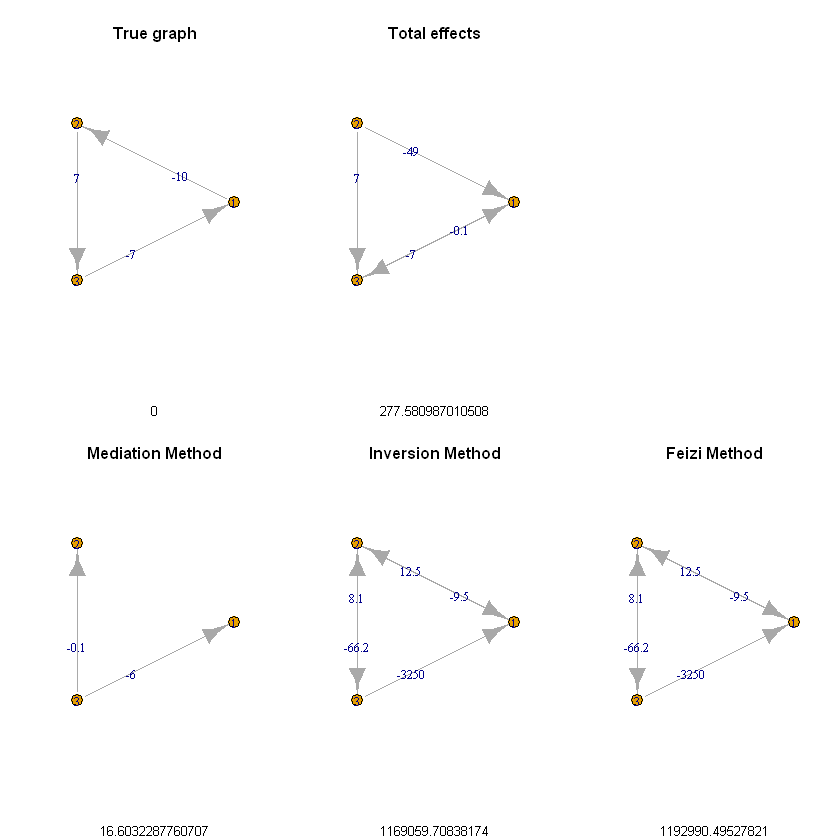

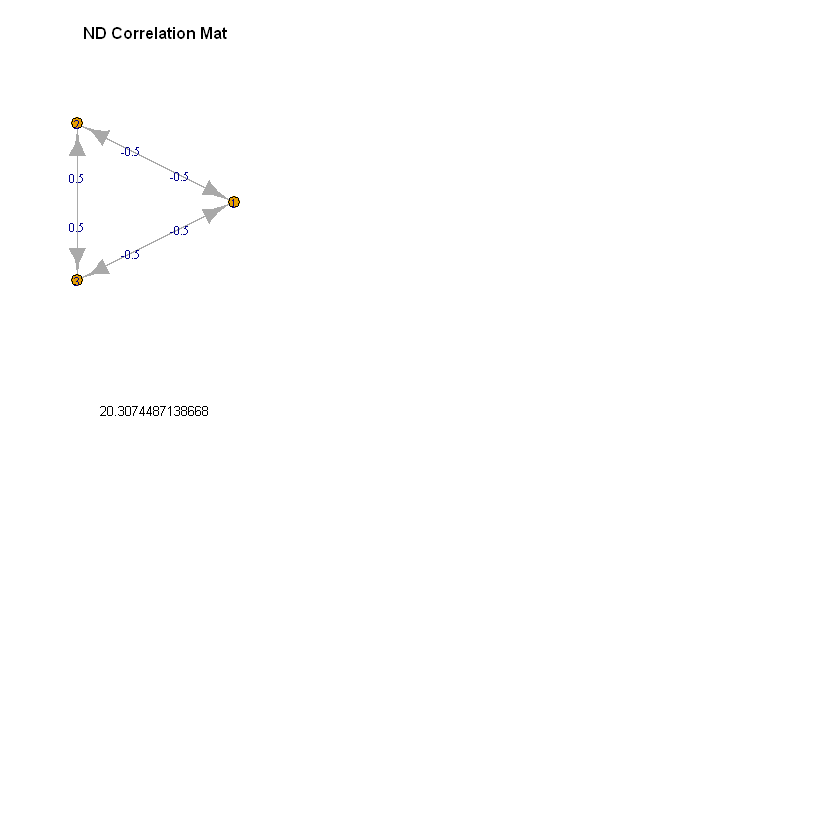

In [7]:
# Data checks
single_test <- function(gsize, datsize, nedges, ncycles, scycles, prRes=FALSE){
    dat <- init_data(datsize, gsize)
    #print(dat$d)
    dat <- graph_gen(ncycles, scycles, nedges, dat)
    #print(dat$d)
    print(dat)
    res <- graph_mr(dat) 
    #print(dat$g)
    #print(res$b)
    corr <- make_cor_mat(dat$d)

    # library seems better suited to dagitty dags, so will sort when those are in
    #mrpc <- MRPC(dat$d, list(corr,500000),0)

    res1 <- mediation_method(res)
    res2 <- inversion_method(res)
    res3 <- deconvolution_method(res)
    res4 <- deconv_corr(corr$b)
    MSE1=meanSquareError(res1, dat$r)
    MSE2=meanSquareError(res2, dat$r)
    MSE3=meanSquareError(res3, dat$r)
    MSE4=meanSquareError(res4, dat$r)
    MSEB=meanSquareError(res$b, dat$r)
    # res5 <- abs(res4) * res$b
    # res6 <- abs(corr$b) * res$b
    #diag(dat$r) <- NA
    resall <- rbind(
        data.frame(estimate=c(res1), truth=c(dat$r), method="Mediation", mse=MSE1),
        data.frame(estimate=c(res2), truth=c(dat$r), method="Inversion", mse=MSE2),
        data.frame(estimate=c(res3), truth=c(dat$r), method="Feizi", mse=MSE3),
        data.frame(estimate=c(res4), truth=c(dat$r), method="ND Correlation mat", mse=MSE4),
        data.frame(estimate=c(res$b), truth=c(dat$r), method="Total effects", mse=MSEB)
        
    #     data.frame(estimate=c(res5), truth=c(dat$r), method="?? Correlation mat"),
    #     data.frame(estimate=c(res6), truth=c(dat$r), method="?? Correlation mat")
    )

    if(prRes){
        par(mfrow=c(2,3))
        plot_from_matrix(dat$r, "True graph", 0)
        plot_from_matrix(res$b, "Total effects" ,MSEB)
        plot(1, type="n", axes=F, xlab="", ylab="")
        plot_from_matrix(res1, "Mediation Method" , MSE1)
        plot_from_matrix(res2, "Inversion Method" , MSE2)
        plot_from_matrix(res3, "Feizi Method" , MSE3)
        plot_from_matrix(res4, "ND Correlation Mat" , MSE4)
        # plot_from_matrix(res5, "ND?? Correlation mat")
        # plot_from_matrix(res6, "X Correlation mat")
    }
    return(resall)
}

# dat <- make_edge(1,2,2, dat)
# dat <- make_edge(2,3,3, dat)
# dat <- make_edge(1,3,7, dat)
# dat <- make_edge(1,4,-2, dat)
# dat <- make_edge(2,4,-4, dat)

do_test <- function(iter, nodes, observations, edges, cycles, cycle_size){
    avgRes <- rbind(
        data.frame(mseTot=0,mseAvg=0,method="Mediation"),
        data.frame(mseTot=0,mseAvg=0,method="Inversion Method"),
        data.frame(mseTot=0,mseAvg=0,method="Feizi Method"),
        data.frame(mseTot=0,mseAvg=0,method="ND Correlation Mat")
    )
    for(it in 1:iter){
        pr = FALSE
        if (it == 1){
            pr = TRUE
        }
        tempRes <- single_test(nodes, observations, edges, cycles, cycle_size, prRes = pr)
        tempMse <- tempRes['mse']
        avgRes[1, 'mseTot'] <- avgRes[1, 'mseTot'] + tempMse[1, 'mse']
        avgRes[2, 'mseTot'] <- avgRes[2, 'mseTot'] + tempMse[1 + (nodes^2), 'mse']
        avgRes[3, 'mseTot'] <- avgRes[3, 'mseTot'] + tempMse[1 + (nodes^2)*2, 'mse']
        avgRes[4, 'mseTot'] <- avgRes[4, 'mseTot'] + tempMse[1 + (nodes^2)*3, 'mse']
        
    }
    avgRes[1, 'mseAvg'] <- avgRes[1, 'mseTot'] / iter
    avgRes[2, 'mseAvg'] <- avgRes[2, 'mseTot'] / iter
    avgRes[3, 'mseAvg'] <- avgRes[3, 'mseTot'] / iter
    avgRes[4, 'mseAvg'] <- avgRes[4, 'mseTot'] / iter
    print(avgRes[1, 'mseAvg'])
    print(avgRes[2, 'mseAvg'])
    print(avgRes[3, 'mseAvg'])
    print(avgRes[4, 'mseAvg'])
    
    print("Done")
}
    
do_test(1, 3, 50000, 0, 1, 3)

Warning message in glasso(C, 0):
"With rho=0, there may be convergence problems if the input matrix 
 is not of full rank"

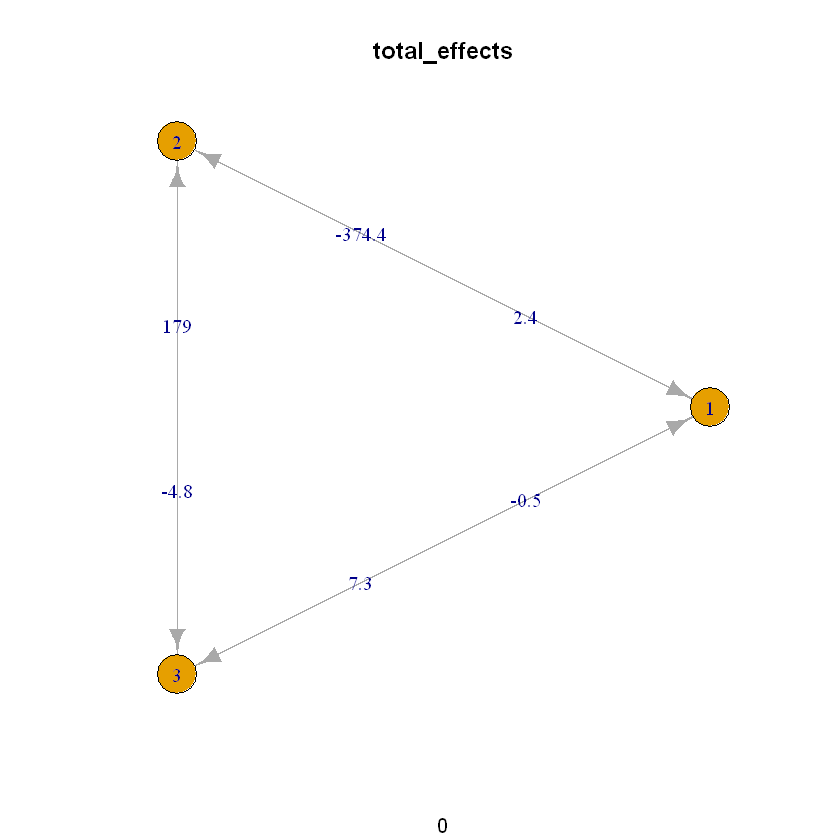

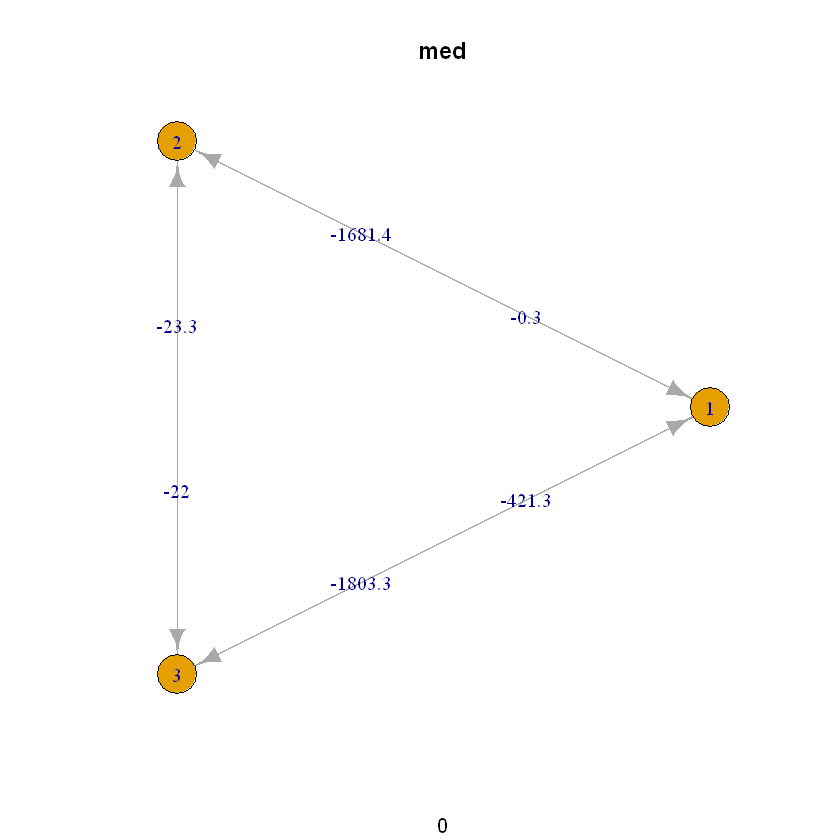

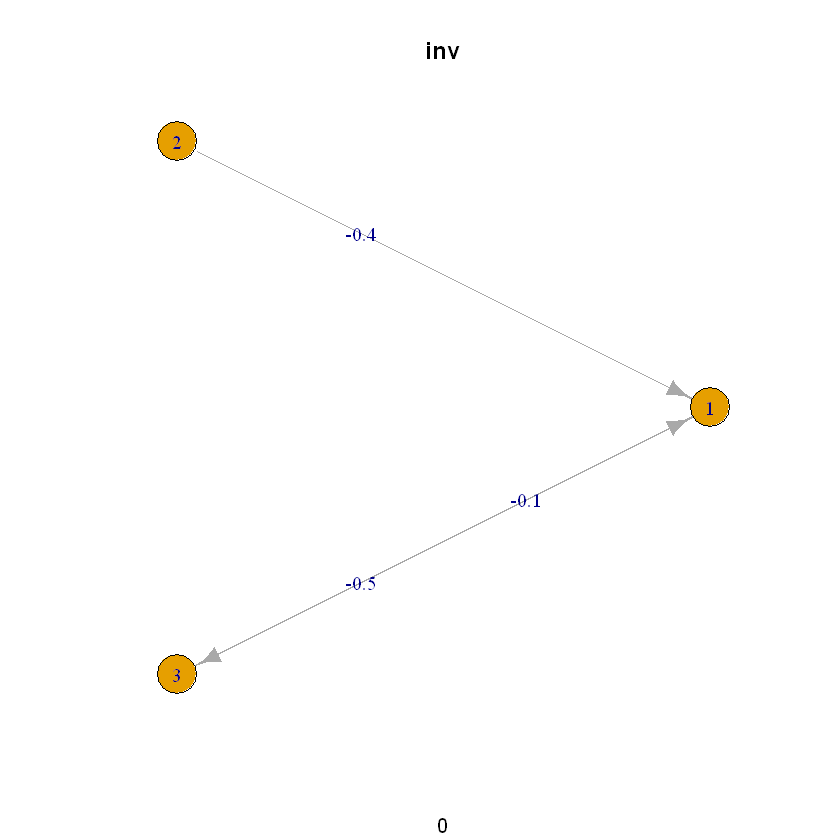

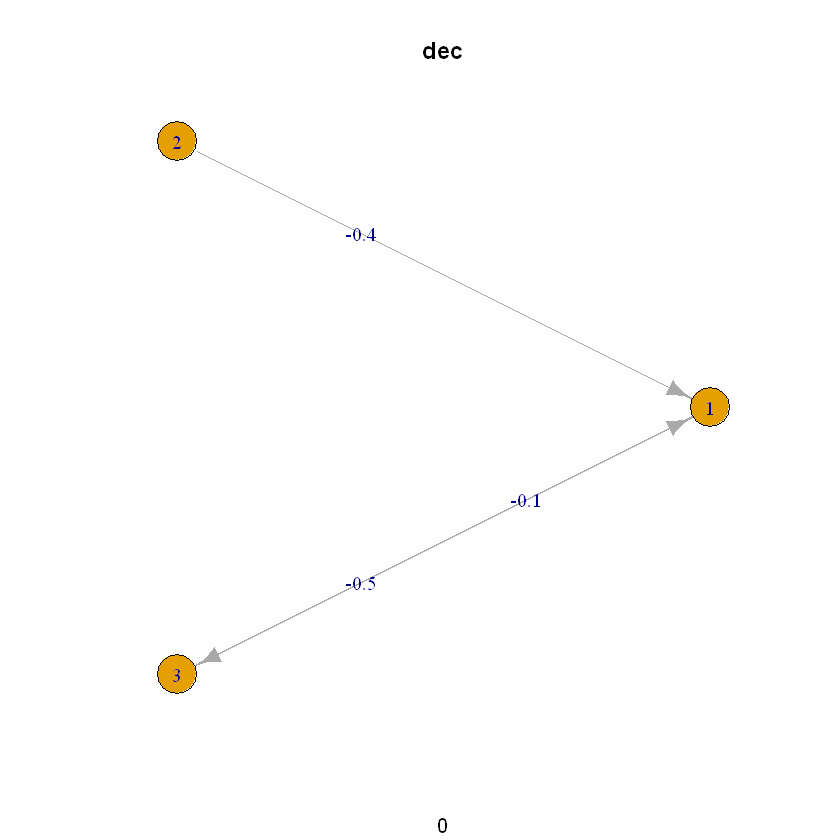

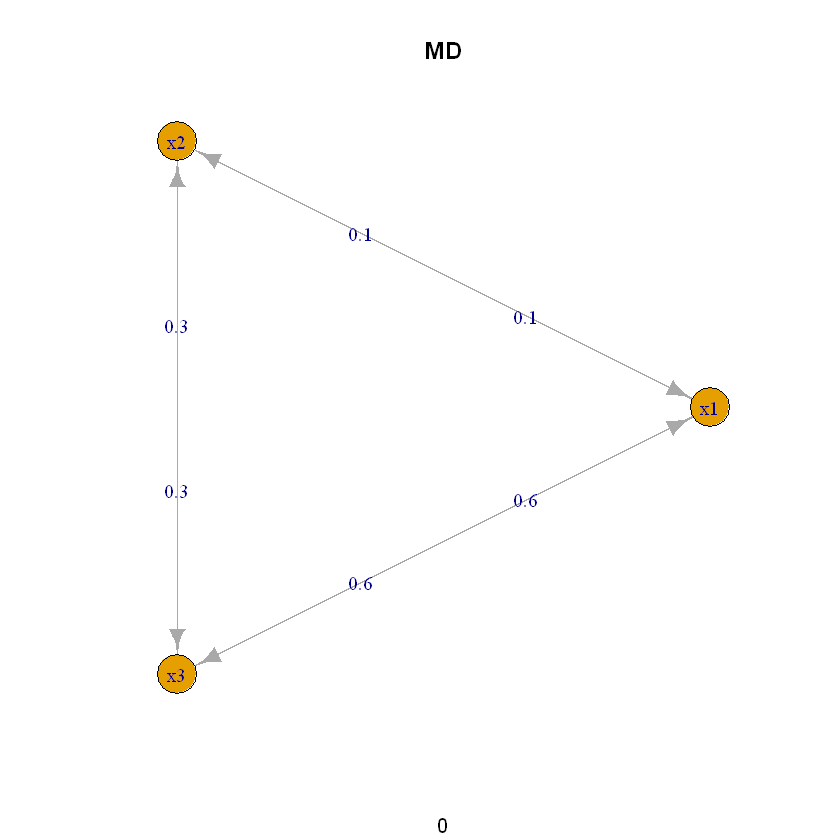

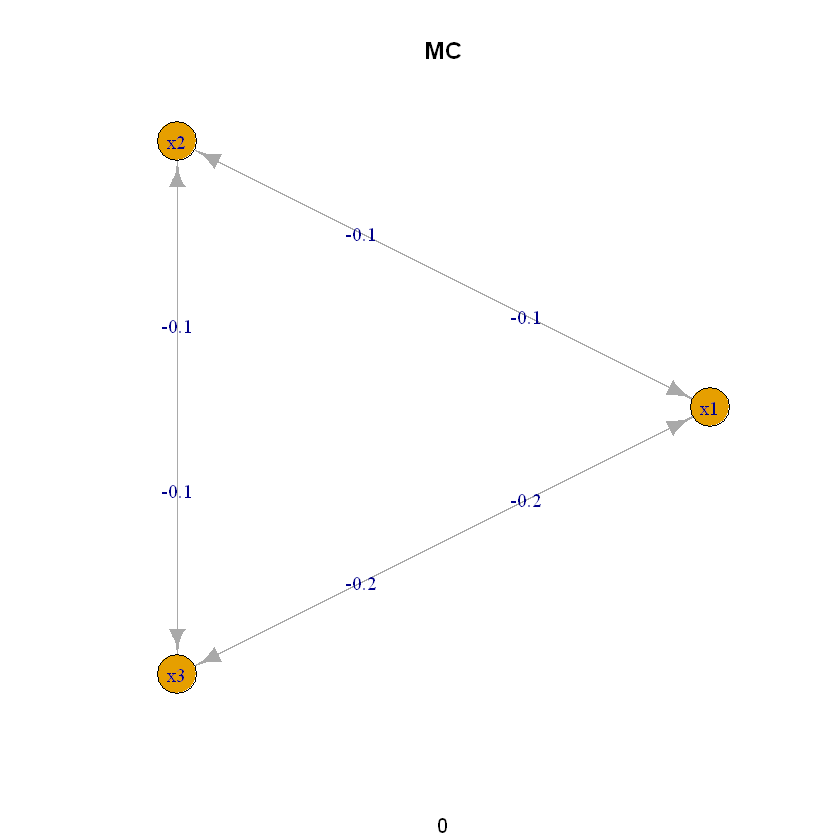

           x1         x2         x3
x1 -0.3062927  0.1133368  0.5883635
x2  0.1133368 -0.1147196  0.2893746
x3  0.5883635  0.2893746 -0.3698893
            x1          x2         x3
x1  1.04308200 -0.07085677 -0.1912134
x2 -0.07085677  1.02037944 -0.1127424
x3 -0.19121344 -0.11274243  1.0506186
$w
           [,1]       [,2]      [,3]
[1,] 1.00000000 0.09062555 0.1917259
[2,] 0.09062555 1.00000000 0.1238044
[3,] 0.19172589 0.12380444 1.0000000

$wi
            [,1]        [,2]       [,3]
[1,]  1.04308201 -0.07085681 -0.1912134
[2,] -0.07085686  1.02037945 -0.1127424
[3,] -0.19121343 -0.11274242  1.0506186

$loglik
[1] -4.413561

$errflag
[1] 0

$approx
[1] FALSE

$del
[1] 4.023605e-08

$niter
[1] 1



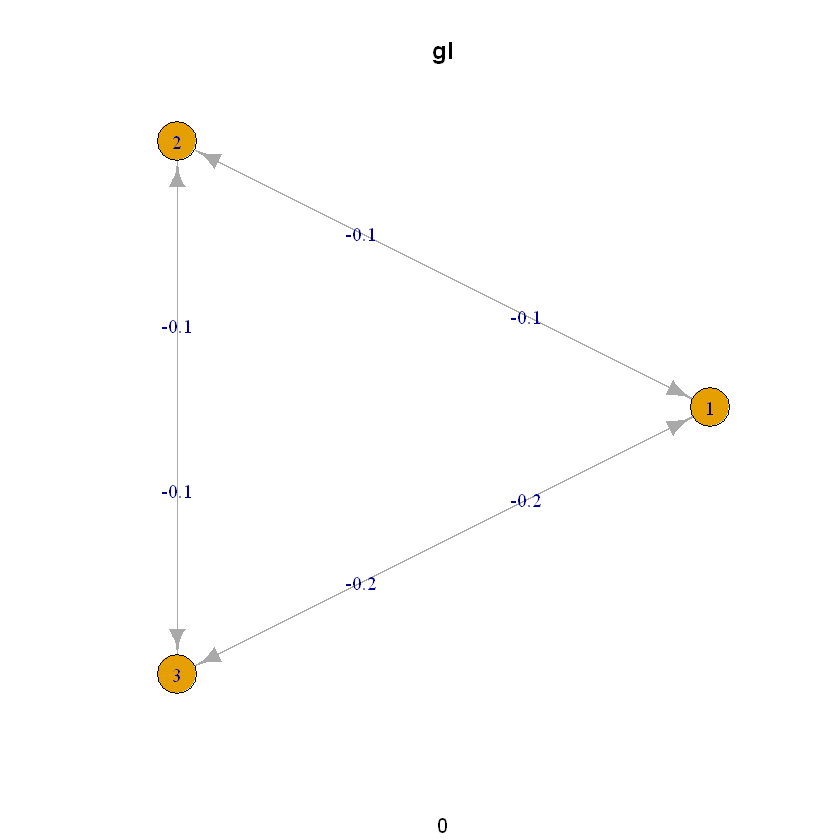

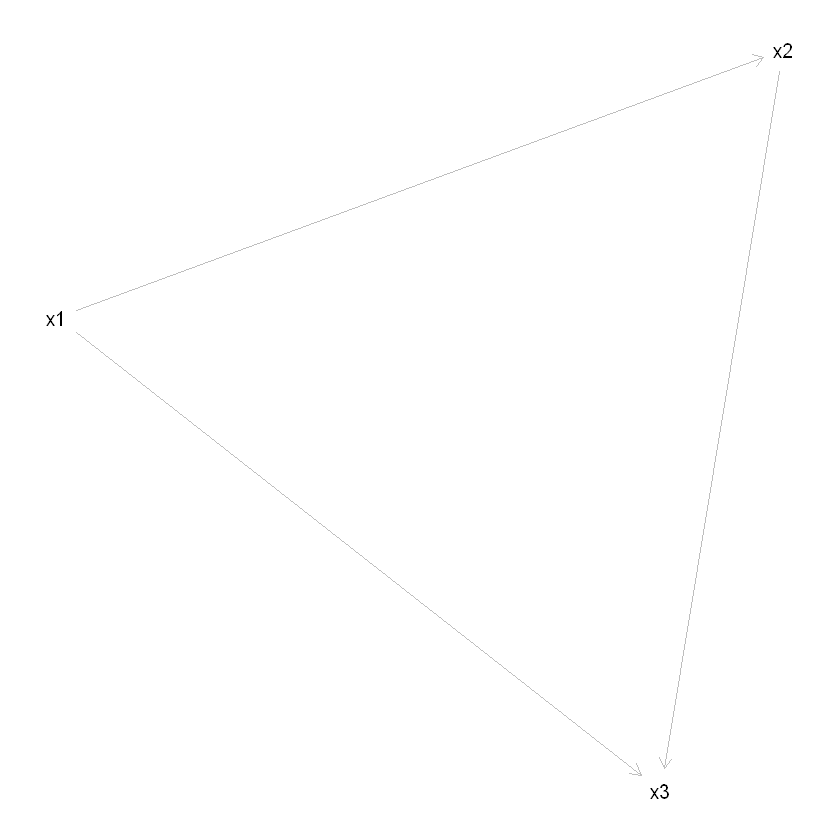

In [25]:
# dag attempts

run_dag_tests <- function(nodes, observations){
    d <- randomDAG(nodes, 0.5)
    d <- graphLayout(d)
    data <- simulateSEM(d, b.default = 0.15, standardized = FALSE, N = observations)
    g <- scale(matrix(rbinom(observations*nodes, 2, 0.5), observations))
    res <- graph_mr(list(d=data, g=g))
    res1 <- mediation_method(res)
    res2 <- inversion_method(res)
    res3 <- deconvolution_method(res)
    C <- cor(data)
    gl <- glasso(C,0)
    MD <- deconv_corr(C)
    MC <- solve(C)
    plot_from_matrix(res$b, "total_effects", 0)
    plot_from_matrix(res1, "med", 0)
    plot_from_matrix(res2, "inv", 0)
    plot_from_matrix(res3, "dec", 0)
    plot_from_matrix(MD,"MD",0)
    plot_from_matrix(MC,"MC",0)
    plot_from_matrix(gl$wi,"gl",0)
    print(MD)
    print(MC)
    print(gl)
    plot(d)
}

run_dag_tests(3, 500)